In [1]:
# Import necessary libraries and check GPU availability

import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import UpSampling2D, concatenate, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available and will be used.")
    for gpu in gpus:
        print(f"GPU: {gpu}")
else:
    print("GPU is not available, using CPU instead.")

GPU is available and will be used.
GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# Dataset path (fold2-selected)
train_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Augmented Images/Augmented Images/FOLDS_AUG/fold2_AUG/Train'
valid_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold2/Valid'
test_loc = '/kaggle/input/mpox-skin-lesion-dataset-version-20-msld-v20/Original Images/Original Images/FOLDS/fold2/Test'

In [3]:
img_size = (224, 224)
batch_size = 16

In [4]:
# Function to create data augmentation pipelines
def augment_class_specific(class_name):
    if class_name in ['Chickenpox', 'Monkeypox']:
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=70,       
            width_shift_range=0.6,   
            height_shift_range=0.6,
            shear_range=0.5,         
            zoom_range=0.6,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=[0.4, 1.6],  
            fill_mode='nearest',
            preprocessing_function=lambda img: tf.image.random_contrast(img, lower=0.7, upper=1.3)
        )
    else:
        return ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.4,
            height_shift_range=0.4,
            shear_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            brightness_range=[0.7, 1.3],
            fill_mode='nearest'
        )

# Test data augmentation (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Function to load data with class-specific augmentations
def load_data():
    train_datagen = augment_class_specific("Chickenpox")
    validation_datagen = augment_class_specific("Monkeypox")
    
    train_generator = train_datagen.flow_from_directory(
        train_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    validation_generator = validation_datagen.flow_from_directory(
        valid_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical'
    )
    
    test_generator = test_datagen.flow_from_directory(
        test_loc, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
    )
    
    return train_generator, validation_generator, test_generator

train_generator, validation_generator, test_generator = load_data()

Found 7126 images belonging to 6 classes.
Found 164 images belonging to 6 classes.
Found 82 images belonging to 6 classes.


In [6]:
# Check class indices to ensure they are correct
print(f"Class indices for the training data: {train_generator.class_indices}")

Class indices for the training data: {'Chickenpox': 0, 'Cowpox': 1, 'HFMD': 2, 'Healthy': 3, 'Measles': 4, 'Monkeypox': 5}


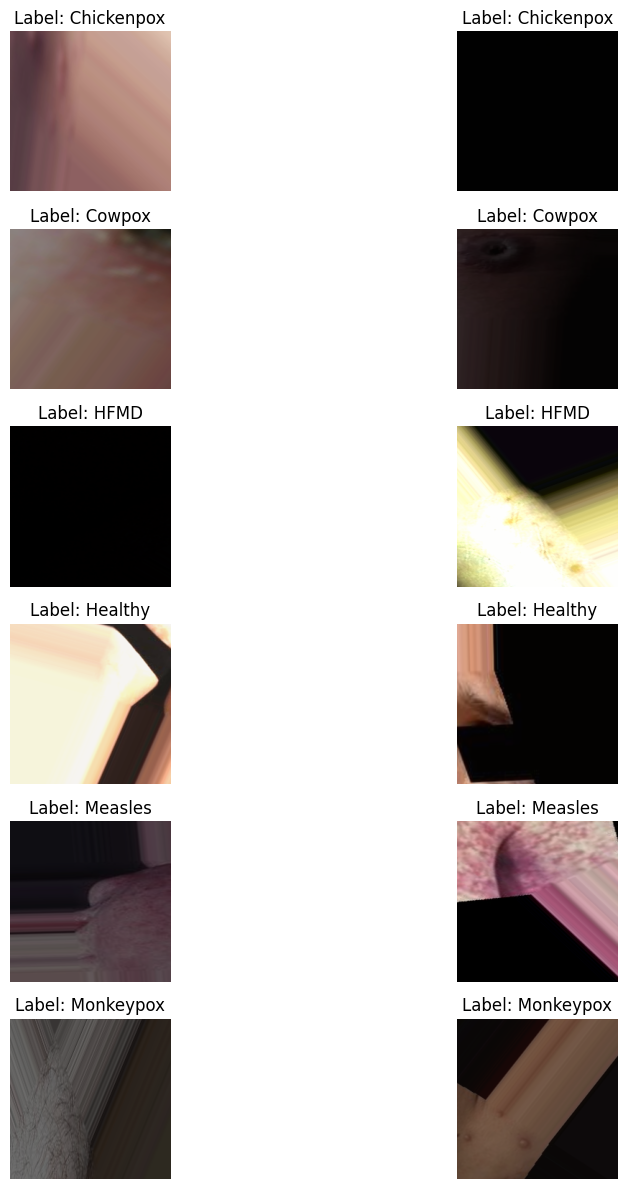

In [7]:
def plot_images_per_class(generator, num_images_per_class=2):
    # Invert the class_indices dictionary to get label -> class name mapping
    class_indices = {v: k for k, v in generator.class_indices.items()}
    num_classes = len(class_indices)
    
    # Initialize a dictionary to store images for each class
    images_per_class = {class_name: [] for class_name in class_indices.values()}

    # Loop until we have collected enough images for each class
    while any(len(images) < num_images_per_class for images in images_per_class.values()):
        images, labels = next(generator)
        
        # Process each image in the batch
        for img, label in zip(images, labels):
            class_label = np.argmax(label)  # Find the index of the one-hot encoded label
            class_name = class_indices[class_label]  # Get the class name from the class indices
            
            # Only add if we haven't collected enough images for this class
            if len(images_per_class[class_name]) < num_images_per_class:
                images_per_class[class_name].append(img)
    
    # Now that we have enough images, let's plot them
    plt.figure(figsize=(12, num_classes * 2))  # Adjust the figure size based on the number of classes
    img_idx = 1
    for class_name, images in images_per_class.items():
        for img in images:
            plt.subplot(num_classes, num_images_per_class, img_idx)
            img_idx += 1
            
            # Scale the image if necessary
            if img.max() > 1:
                img = img / 255.0
            
            plt.imshow(img)
            plt.title(f"Label: {class_name}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 2 images from each class from the training set
plot_images_per_class(train_generator, num_images_per_class=2)

In [8]:
# Compute class weights to handle imbalance
labels = train_generator.classes
class_weights_resnet101 = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(labels), 
                                                  y=labels)
class_weights_dict_resnet101 = dict(enumerate(class_weights_resnet101))

In [9]:
# Build the ResNet101 model
def build_resnet101_model(input_shape=(224, 224, 3), num_classes=6):
    base_model = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
    # Fine-tune the last 150 layers
    for layer in base_model.layers[-150:]:
        layer.trainable = True
    
    # Add custom layers for classification
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Build the model
model_resnet101 = build_resnet101_model()

# Callbacks for early stopping, learning rate reduction, and model checkpoint
checkpoint_resnet101 = ModelCheckpoint("best_model_resnet101.keras", monitor='val_accuracy', save_best_only=True)
early_stopping_resnet101 = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
lr_scheduler_resnet101 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Train the model with class weights and callbacks
history_resnet101 = model_resnet101.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weights_dict_resnet101,
    callbacks=[checkpoint_resnet101, early_stopping_resnet101, lr_scheduler_resnet101]
)

# Evaluate the model on the test set
test_loss_resnet101, test_acc_resnet101 = model_resnet101.evaluate(test_generator)
print(f"Test accuracy: {test_acc_resnet101}")

# Save the final model
model_resnet101.save('final_resnet101_model.keras')

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729384316.085078     115 service.cc:145] XLA service 0x7dce180021a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729384316.085130     115 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729384364.535693     115 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


283/446 ━━━━━━━━━━━━━━━━━━━━ 1:09 425ms/step - accuracy: 0.1829 - loss: 2.9162

I0000 00:00:1729384530.464037     115 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_45', 456 bytes spill stores, 456 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_53', 224 bytes spill stores, 224 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_45', 224 bytes spill stores, 224 bytes spill loads



446/446 ━━━━━━━━━━━━━━━━━━━━ 363s 562ms/step - accuracy: 0.1959 - loss: 2.8417 - val_accuracy: 0.1341 - val_loss: 26.6346 - learning_rate: 1.0000e-05
Epoch 2/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 195s 386ms/step - accuracy: 0.2846 - loss: 2.2870 - val_accuracy: 0.3598 - val_loss: 2.8917 - learning_rate: 1.0000e-05
Epoch 3/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 173s 385ms/step - accuracy: 0.3304 - loss: 2.1122 - val_accuracy: 0.4146 - val_loss: 1.5745 - learning_rate: 1.0000e-05
Epoch 4/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 174s 387ms/step - accuracy: 0.3726 - loss: 1.8613 - val_accuracy: 0.4878 - val_loss: 1.3958 - learning_rate: 1.0000e-05
Epoch 5/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 173s 385ms/step - accuracy: 0.3970 - loss: 1.7654 - val_accuracy: 0.5244 - val_loss: 1.2540 - learning_rate: 1.0000e-05
Epoch 6/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 173s 383ms/step - accuracy: 0.4299 - loss: 1.6429 - val_accuracy: 0.5366 - val_loss: 1.4604 - learning_rate: 1.0000e-05
Epoch 7/50
446/446 ━━━━━━━━━━━━━━━━━━━━ 175s 388ms

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Classification Report for ResNet101 Model:
              precision    recall  f1-score   support

  Chickenpox       0.50      0.82      0.62        11
      Cowpox       1.00      0.75      0.86         4
        HFMD       0.83      0.95      0.88        20
     Healthy       0.82      0.82      0.82        11
     Measles       0.50      0.80      0.62         5
   Monkeypox       0.84      0.52      0.64        31

    accuracy                           0.73        82
   macro avg       0.75      0.78      0.74        82
weighted avg       0.78      0.73      0.73        82

Precision: 0.7759390522967015
Recall: 0.7317073170731707
F1 Score: 0.7298475526468563


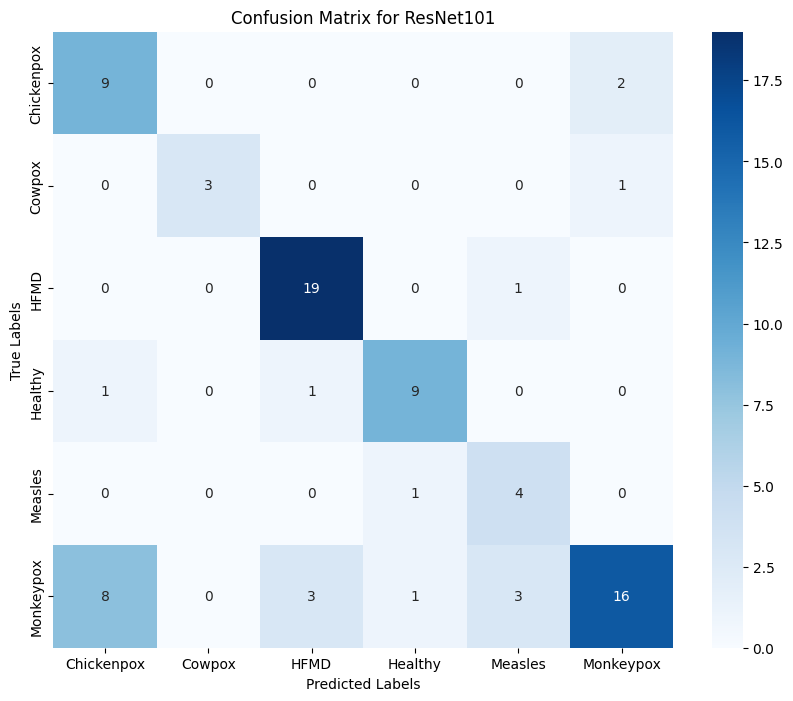

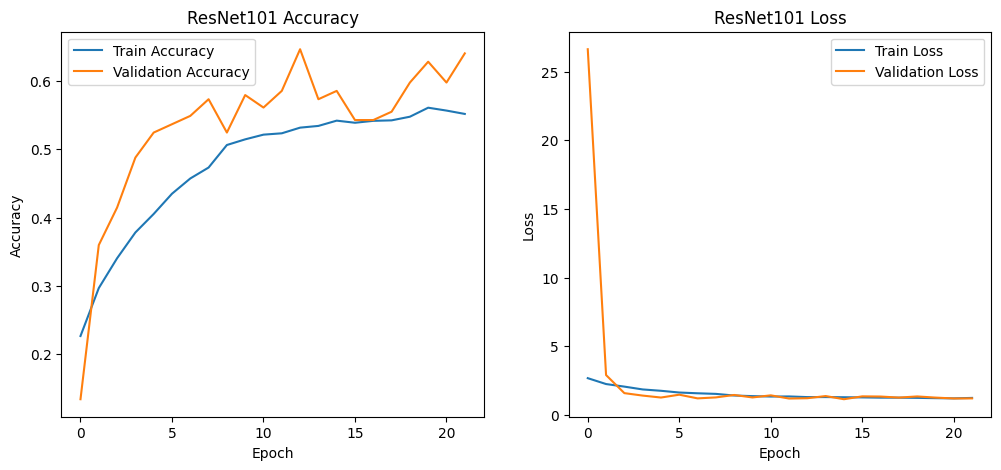

In [10]:
# Predictions on the test set
preds_resnet101 = model_resnet101.predict(test_generator)
y_preds_resnet101 = np.argmax(preds_resnet101, axis=1)
y_true_resnet101 = test_generator.classes

# Classification report
print("Classification Report for ResNet101 Model:")
print(classification_report(y_true_resnet101, y_preds_resnet101, target_names=test_generator.class_indices.keys()))

# Compute accuracy, precision, recall, and F1-score
accuracy_resnet101 = accuracy_score(y_true_resnet101, y_preds_resnet101)
precision_resnet101 = precision_score(y_true_resnet101, y_preds_resnet101, average='weighted', zero_division=0)
recall_resnet101 = recall_score(y_true_resnet101, y_preds_resnet101, average='weighted', zero_division=0)
f1_resnet101 = f1_score(y_true_resnet101, y_preds_resnet101, average='weighted', zero_division=0)

print(f"Precision: {precision_resnet101}")
print(f"Recall: {recall_resnet101}")
print(f"F1 Score: {f1_resnet101}")

# Confusion matrix
cm_resnet101 = confusion_matrix(y_true_resnet101, y_preds_resnet101)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet101, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix for ResNet101')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Function to plot training history
def plot_training_history(history, model_name="Model"):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Plot training history
plot_training_history(history_resnet101, model_name="ResNet101")